# XRD-CT reconstruction
## run this notebook inside the Tomography / Tomorec / GPU environment 

This notebook will do a simple tomo resontruction for a XRD-CT map (omega-translation flyscan). It requires data from the `.h5` masterfile and the `_pilatus_integrated.h5` file.

### Load data and plot average XRD for the map

In [1]:
%pylab inline
import os
import h5py as h5
import numpy as np
import matplotlib.pyplot as plt
try:
    import tomopy
except ModuleNotFoundError as err:
    raise Exception('tomopy not found: try changing your server to "Tomography/Tomorec/GPU": in File->Hub control panel')

#To import DanMAX from the folder above:
import sys
sys.path.append('../')
import DanMAX as DM
style = DM.darkMode(style_dic={'figure.figsize':'large'})

Populating the interactive namespace from numpy and matplotlib
Change to HDF5 server to load all modules
Unable to load lib/texture.py
Unable to load lib/integration.py
Unable to load lib/parallel.py
Unable to load lib/archiver_danmax.py
DanMAX.py Version 3.5.1


The nominal and registred motor positions for sam_y do not match!
The nominal and registred motor positions for ea_sams2_ry do not match!
No lakeshore temperature available
No cryo stream temperature available


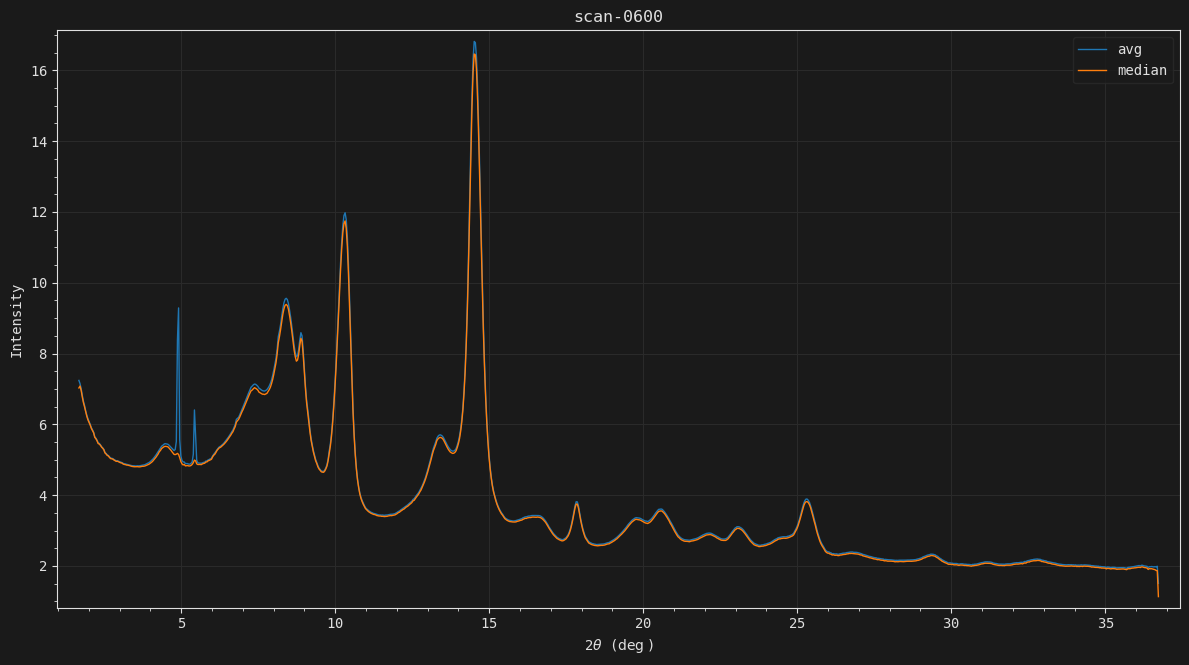

In [19]:
# Define scan location:
fname = DM.findScan(600)

# get motor names, nominal- and registered moto positions
M1, M2 = DM.getMotorSteps(fname,proposal=None,visit=None)
M1, nom_1, reg_1 = M1
M2, nom_2, reg_2 = M2

# assign rotation and translation positions
if 'ry' in M1 or 'rx' in M1:
    M_rot, M_trans = M1, M2
    rot, trans = reg_1, reg_2
    # data shape  (rotation, translation)
    shape_2d = (nom_1.shape[0],nom_2.shape[0])
elif 'ry' in M2 or 'rx' in M2:
    M_rot, M_trans = M2, M1
    rot, trans = reg_2, reg_1
    # data shape  (rotation, translation)
    shape_2d = (nom_2.shape[0],nom_1.shape[0])
else:
    print(f'Unable to guess rotational motor, assuming {M1} is rotational')
    M_rot, M_trans = M1, M2
    rot, trans = reg_1, reg_2
    shape_2d = (nom_1.shape[0],nom_2.shape[0])
    
# read azimuthally binned data
aname = DM.getAzintFname(fname)
data = DM.getAzintData(aname)

I = data['I']
# determine and read radial unit
if type(data['q']) != type(None):
    x = data['q']
    Q = True
else:
    x = data['tth']
    Q = False

# get meta data
meta = DM.getMetaData(fname)
I0 = meta['I0']

exposure = DM.getExposureTime(fname)

# normalize to I0
I = (I.T/I0).T
I[I<0.]=0.

zero_mask = np.nanmean(I,axis=0)>0.

I = I[:,zero_mask]
x = x[zero_mask]

# calculate average diffraction pattern
I_avg = np.nanmean(I,axis=0)
I_median = np.nanmedian(I,axis=0)

# plot average pattern
plt.figure()
plt.title(DM.getScan_id(fname))
plt.plot(x,I_avg,label='avg')
plt.plot(x,I_median,label='median')
if Q:
    plt.xlabel(r'Q ($\AA^{-1}$)')
else:
    plt.xlabel(r'2$\theta$ ($\deg$)')
plt.ylabel('Intensity')
plt.legend()

#### Reshape XRD data for tomo reconstruction

In [3]:
# reshape the motor position data (rot, trans)
rot_2d = rot.reshape(shape_2d)
trans_2d = trans.reshape(shape_2d)
# reshape the diffraction data (rot, trans, radial)
I_2d = I.reshape(*shape_2d,I.shape[-1])

# reshape to adhere to the tomopy definition (rot,radial,trans)
proj = I_2d.transpose(0,2,1)
theta = rot_2d[:,0]*np.pi/180

#### Find the rotation center and plot a sinogram for the maximum point in the average diffraction pattern
For visual confirmation that everything is OK

Reconstructing 1 slice groups with 1 master threads...
Reconstructing 1 slice groups with 1 master threads...
Reconstructing 1 slice groups with 1 master threads...
Reconstructing 1 slice groups with 1 master threads...
Reconstructing 1 slice groups with 1 master threads...
Reconstructing 1 slice groups with 1 master threads...
Reconstructing 1 slice groups with 1 master threads...
Reconstructing 1 slice groups with 1 master threads...
Reconstructing 1 slice groups with 1 master threads...
Reconstructing 1 slice groups with 1 master threads...
Reconstructing 1 slice groups with 1 master threads...
Reconstructing 1 slice groups with 1 master threads...
Reconstructing 1 slice groups with 1 master threads...
Reconstructing 1 slice groups with 1 master threads...
Reconstructing 1 slice groups with 1 master threads...
The padded rotation center is 161.52 px
The unpadded rotation center is -54.80 mm


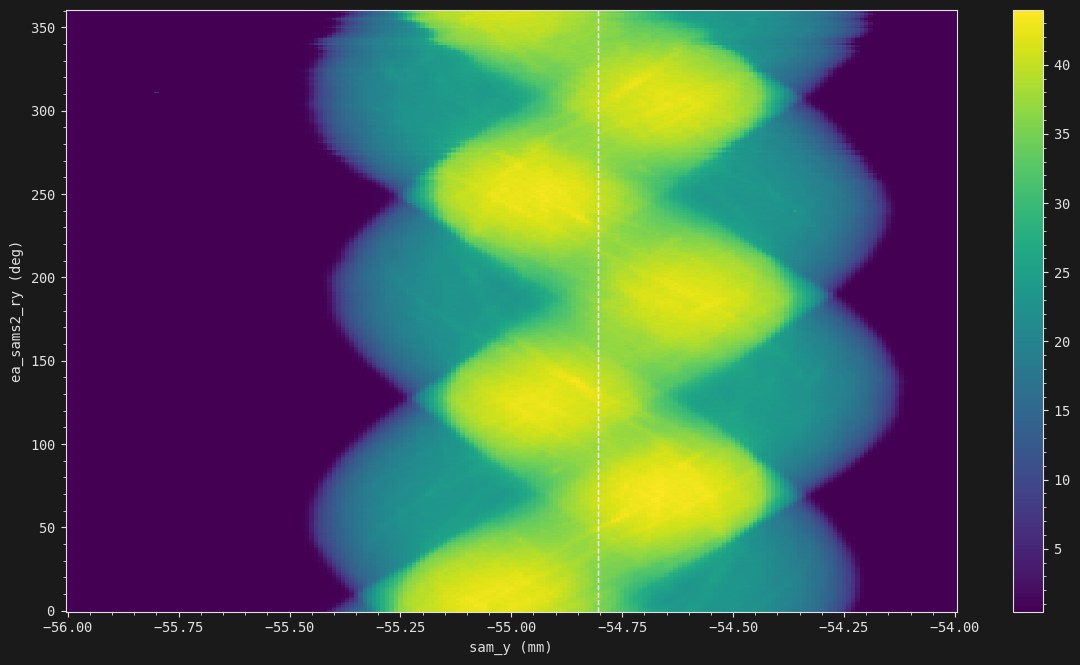

In [4]:
#add padding along the translation axis
proj = I_2d.transpose(0,2,1)
proj = tomopy.misc.morph.pad(proj, axis=2, mode='edge')

#find rotation center (pick an algorithm)
rot_center = tomopy.find_center(proj, theta)[0]
#rot_center = tomopy.find_center_pc(proj[0], proj[-1], tol=0.5)
#rot_center = tomopy.find_center_vo(proj)

print('The padded rotation center is {:.2f} px'.format(rot_center))

# difference between unpadded and padded projection
pad = round((proj.shape[-1] - I_2d.shape[1])/2)
# mm per pixel conversion
mm_per_px = np.mean(np.diff(trans_2d[0,:]))
# rotation center in mm
rot_cen_mm = (rot_center-pad)*mm_per_px+trans_2d[0,0]

print('The unpadded rotation center is {:.2f} mm'.format(rot_cen_mm))

plt.figure()
plt.pcolormesh(trans_2d[0],
               theta*180/np.pi,
               I_2d.transpose(0,2,1)[:,np.nanargmax(I_avg),:],
               shading='auto')
plt.axvline(rot_cen_mm,color='w',linestyle='dashed')
plt.xlabel(f'{M_trans} (mm)')
plt.ylabel(f'{M_rot} (deg)')
plt.grid(False)
plt.colorbar()

#### Perform the reconstruction

In [16]:
#tomo reconstruction (radial, padded shape, padded shape)
recon = tomopy.recon(proj, theta, center=rot_center, algorithm='gridrec', filter_name='hamming')
print(recon.shape)
recon = recon[:,pad:-pad,pad:-pad]
print(recon.shape)

# scale the reconstructed intensities to the number of projections and exposure time
recon = recon*exposure*rot_2d.shape[0]

# create x/y maps in mm
x_map, y_map = np.mgrid[0:recon.shape[1],0:recon.shape[2]]*mm_per_px

Reconstructing 8 slice groups with 8 master threads...
(954, 285, 285)
(954, 201, 201)


#### Plot the reconstruction

/opt/conda/envs/maxiv-jup-conda-env-tomography-tomorec/lib/python3.7/site-packages/ipykernel_launcher.py:9: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  if __name__ == '__main__':


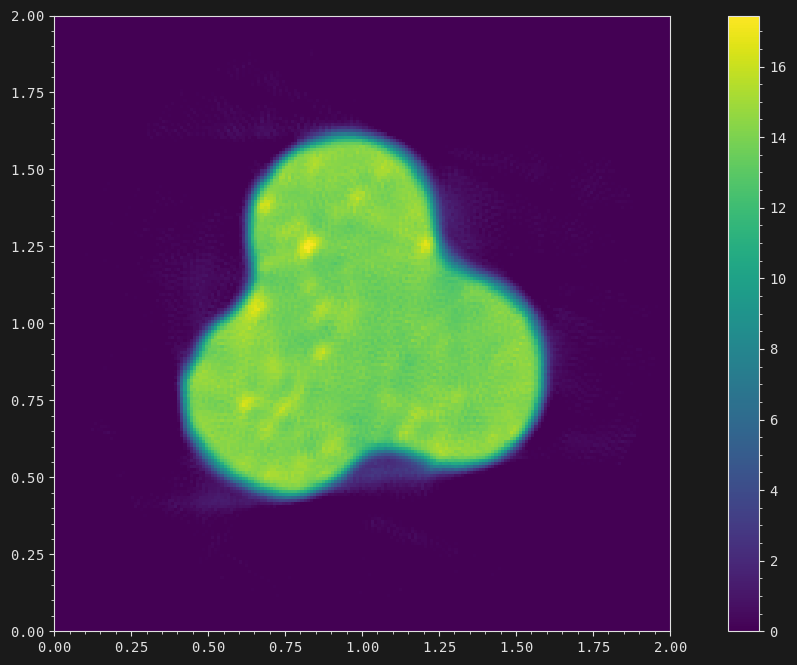

In [17]:
#add a circular mask
recon = tomopy.circ_mask(recon, axis=0, ratio=0.95)

plt.figure()
plt.pcolormesh(x_map,
               y_map,
               recon[np.argmax(I_avg)],
               cmap='viridis',
               vmin=0)
plt.colorbar()
plt.gca().set_aspect('equal')

### Save the reconstruction as a map

In [63]:
maps = {'x_map':x_map ,
        'y_map':y_map,
        'xrd_map':recon.T,
        'x_xrd':x,
        'Q':Q,
       }

DM.mapping.save_maps(maps=maps, scans=[fname])

KeyError: 'cake_map'

### Plot region-of-interest maps

In [ ]:
# define the approximate region of interest in scattering units
#            label    :     roi
regions = {'region_1' : [4.8,5.1],
           'region_2' : [9.4,11.4],
          }

# plot the region of interest for the average pattern
plt.figure()
plt.title(DM.getScan_id(fname))
plt.plot(x,I_avg,label='average pattern')
# loop through all peaks
for region in regions:
    roi = regions[region]
    roi = (x>roi[0]) & (x<roi[1])
    plt.plot(x[roi],I_avg[roi],'.',label=region)
plt.ylabel('I [a.u.]')
if Q:
    plt.xlabel(r'Q [$\AA^{-1}$]')
else:
    plt.xlabel(r'2$\theta$ [$\deg$]')
plt.legend()

In [ ]:
# Set the number of columns for the figure
cols = 3

rows = int(len(regions)/cols) + (len(regions)%cols!=0)

# initialize figure
fig, axes = plt.subplots(rows,cols,sharex=True,sharey=True)
#fig.set_size_inches(12,8)
fig.suptitle(DM.getScan_id(fname))
axes = axes.flatten()

# calculate scale bar values
scale_500um = .5/(mm_per_px)
offset = recon.shape[1]*0.025

for ax in axes:
    ax.set_xticks([])
    ax.set_yticks([])

for k,region in enumerate(regions):
    roi = regions[region]
    roi = (x>roi[0]) & (x<roi[1])
    

    im = np.mean(recon[roi],axis=0)
    
    # plot heatmap
    ax = axes[k]
    ax.set_title(f'{region}')
    ax.grid(False)
    
    vmin = max(im.min(),0)
    ax.imshow(im,vmin=vmin)
    
    ax.plot([offset,offset+scale_500um],
            [offset,offset],
            'w',
            lw=10,
           )
    ax.annotate('500 μm',
                (offset+scale_500um/2,offset*2),
                horizontalalignment='center',
                verticalalignment='top',
               )

# delete surplus plots
for i in range(1,cols*rows-len(regions)+1):
    fig.delaxes(axes[-i])
fig.tight_layout()
    